<a href="https://colab.research.google.com/github/Rahul-Jain-16/facebook-ad-campaign-sql-analysis/blob/main/facebook_ads_SQL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%load_ext sql
%sql sqlite://

In [3]:
!pip install kagglehub

import kagglehub

# Download latest version
path = kagglehub.dataset_download("madislemsalu/facebook-ad-campaign")

print("Path to dataset files:", path)

100%|██████████| 21.3k/21.3k [00:00<00:00, 42.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/madislemsalu/facebook-ad-campaign/versions/1


In [4]:
import os
# List all files and subdirectories to find the actual file
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

/root/.cache/kagglehub/datasets/madislemsalu/facebook-ad-campaign/versions/1/data.csv


Load CSV data in SQLite

In [44]:
import pandas as pd
import sqlite3

df = pd.read_csv(f"{path}/data.csv")
df

,ad_id,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
0,708746,2017-08-17,17/08/2017,916,103916,30-34,M,15,17,17,7350.000000,1,1.43,2.0,1.0
1,708749,2017-08-17,17/08/2017,916,103917,30-34,M,16,19,21,17861.000000,2,1.82,2.0,0.0
2,708771,2017-08-17,17/08/2017,916,103920,30-34,M,20,25,22,693.000000,0,0.00,1.0,0.0
3,708815,2017-08-30,30/08/2017,916,103928,30-34,M,28,32,32,4259.000000,1,1.25,1.0,0.0
4,708818,2017-08-17,17/08/2017,916,103928,30-34,M,28,33,32,4133.000000,1,1.29,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138,1314410,2017-08-19,19/08/2017,45-49,F,109,111,114,1129773,252,358.189997,13,2.00,NaN,NaN
1139,1314411,2017-08-19,19/08/2017,45-49,F,110,111,116,637549,120,173.880003,3,0.00,NaN,NaN
1140,1314412,2017-08-19,19/08/2017,45-49,F,111,113,117,151531,28,40.289999,2,0.00,NaN,NaN
1141,1314414,2017-08-17,17/08/2017,45-49,F,113,114,117,790253,135,198.710001,8,2.00,NaN,NaN


Create an SQLite connection:

In [6]:
conn = sqlite3.connect(':memory:')
df.to_sql('facebook_ads', conn, index=False, if_exists= 'replace')

1143

In [7]:
query = '''
SELECT ad_id, campaign_id, SUM(impressions) as total_impressions,
       SUM(clicks) as total_clicks,
       ROUND(SUM(clicks)*1.0 / NULLIF(SUM(impressions),0), 4) as CTR
FROM facebook_ads
GROUP BY ad_id, campaign_id
ORDER BY CTR DESC
LIMIT 10
'''
pd.read_sql(query, conn)

,ad_id,campaign_id,total_impressions,total_clicks,CTR
0,1314308,30-34,3.20,3,0.9375
1,1314298,30-34,2.69,2,0.7435
2,1314330,40-44,1.49,1,0.6711
3,1121953,35-39,1.64,1,0.6098
4,1121839,30-34,1.73,1,0.5780
5,1314297,30-34,7.53,4,0.5312
6,1121869,30-34,2.62,1,0.3817
7,1121897,35-39,2.63,1,0.3802
8,1121871,30-34,2.78,1,0.3597
9,1314364,30-34,11.19,4,0.3575


Click through rate (CTR) = Clicks / Impressions
Conversion Rate (CVR) = Conversion / Clicks
Return on Ad Spend (ROAS) = Conversion Value / Budget
Frequency = Impressions / Reach
Cost per 1000 impressions (CPM)

**Q1. Which campaign had the best ROAS?**

A1. From the below SQL code, it was found that **Campaign_id 916** has the best ROAS of 0.39. *(Return on Ad Spend = Conversion Value / Budget )*

In [9]:
#ROAS
query = '''
SELECT campaign_id,
       ROUND(SUM(spent), 2) AS total_spent,
       ROUND(SUM(total_conversion), 2) AS total_conversion,
       CASE WHEN SUM(spent) > 0
            THEN ROUND(SUM(total_conversion) / SUM(spent), 2)
            ELSE NULL END AS ROAS
FROM facebook_ads
GROUP BY campaign_id
ORDER BY ROAS DESC
'''
pd.read_sql(query, conn)


,campaign_id,total_spent,total_conversion,ROAS
0,916,149.71,58.0,0.39
1,936,2893.37,537.0,0.19
2,1178,16577.16,1050.0,0.06
3,45-49,162.00,NaN,NaN
4,40-44,88.00,NaN,NaN
5,35-39,78.00,NaN,NaN
6,30-34,166.00,NaN,NaN


**Q2. How does performance vary by age?**

A2: There are two metrics which can help us identify this. a) Click through rate (CTR) = Clicks / Impressions, b) Conversion Rate = Conversions / Clicks.

From the table using the below SQL code, it has been observed that
1. Ages in the 60s shows the highest CTRs, suggesting these users are more likely to click on ads - possibly due to less ad fatigue or better targeting

2. 30-49 age groups show very low CTRs - possibly oversaturated or poorly targeted.

3. Only 30-49 age groups have valid conversion data. Despite low CTR, these age groups convert well after clicking - especially 30-34 with a 20% conversion rate.

4. The older age groups had high CTR but no recorded conversions, which could indicate interest but no follow-through.

In summary, 30-34 is the sweet spot: low click rate, but very high intent when they do click. Likely ideal for high-value offers or marketing. Older users click more but don't convert - possibly due to misalignment between ads and product relevance. 30-49 audience is saturated - consider creative refresh or frequency control to fight ad fatigue.

Please see the graph following the SQL code for reference.

In [28]:
query = '''
SELECT
  age,
  ROUND(SUM(clicks) * 1.0 / NULLIF(SUM(impressions), 0), 4) AS ctr,
  ROUND(SUM(total_conversion) * 1.0 / NULLIF(SUM(clicks), 0), 4) AS cvr
FROM facebook_ads
GROUP BY age
ORDER BY cvr DESC
LIMIT 10;
'''

df_age_perf = pd.read_sql(query, conn)
df_age_perf

,age,ctr,cvr
0,30-34,0.0001,0.2008
1,35-39,0.0001,0.1188
2,45-49,0.0002,0.1034
3,40-44,0.0002,0.0883
4,7,0.0676,NaN
5,66,0.0772,NaN
6,65,0.0447,NaN
7,64,0.0378,NaN
8,63,0.0283,NaN
9,36,0.1140,NaN


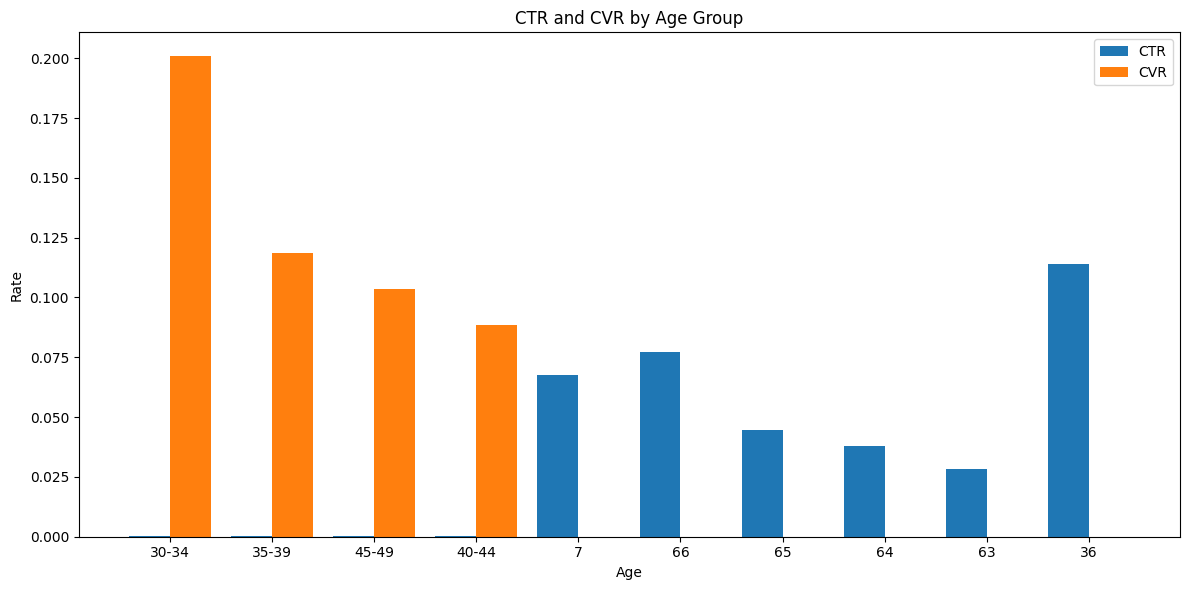

In [29]:
import matplotlib.pyplot as plt

# Convert age to string for x-axis labels
df_age_perf['age'] = df_age_perf['age'].astype(str)

# Set figure size
plt.figure(figsize=(12, 6))

# Bar width and positions
x = range(len(df_age_perf))
bar_width = 0.4

# Plot CTR
plt.bar(x, df_age_perf['ctr'], width=bar_width, label='CTR', align='center')

# Plot CVR next to it (some may be NaN)
plt.bar([i + bar_width for i in x],
        df_age_perf['cvr'].fillna(0), width=bar_width, label='CVR', align='center')

# X-axis labels
plt.xticks([i + bar_width / 2 for i in x], df_age_perf['age'])

# Labels and legend
plt.xlabel('Age')
plt.ylabel('Rate')
plt.title('CTR and CVR by Age Group')
plt.legend()
plt.tight_layout()

plt.show()


**Q3. Are there signs of ad fatigue (CTR drop over time)?**

A3. Observations from the SQL table and python graph:

*   Campaign 1178 shows a clear drop in CTR from 0.0002 to 0.0001, sustained for many days — a textbook sign of gradual ad fatigue.

* Campaign ID "30–34" has very high CTR spikes on some days (up to 0.5871), but fluctuates — indicating non-fatigue, possibly driven by variation in content or targeting.

* Campaign 916 shows CTR dropping to 0.0, then recovers slightly — could suggest a short period of fatigue.

* Other campaigns like 936 and 45–49 show slight declines, but not as clearly as 1178.

In conclusion, Campaign 1178 exhibits strong evidence of ad fatigue, with CTR dropping and staying flat. Other groups have mixed trends — possibly affected by variation in creatives, audiences, or external events.

In [45]:
query = '''
SELECT
  campaign_id,
  reporting_start,
  ROUND(SUM(clicks) * 1.0 / NULLIF(SUM(impressions), 0), 4) AS ctr
FROM facebook_ads
GROUP BY campaign_id, reporting_start
ORDER BY campaign_id, reporting_start;
'''

df_ctr_over_time = pd.read_sql(query, conn)
df_ctr_over_time

,campaign_id,reporting_start,ctr
0,1178,18/08/2017,0.0002
1,1178,19/08/2017,0.0002
2,1178,20/08/2017,0.0002
3,1178,21/08/2017,0.0001
4,1178,22/08/2017,0.0001
...,...,...,...
75,936,26/08/2017,0.0003
76,936,27/08/2017,0.0002
77,936,28/08/2017,0.0002
78,936,29/08/2017,0.0002


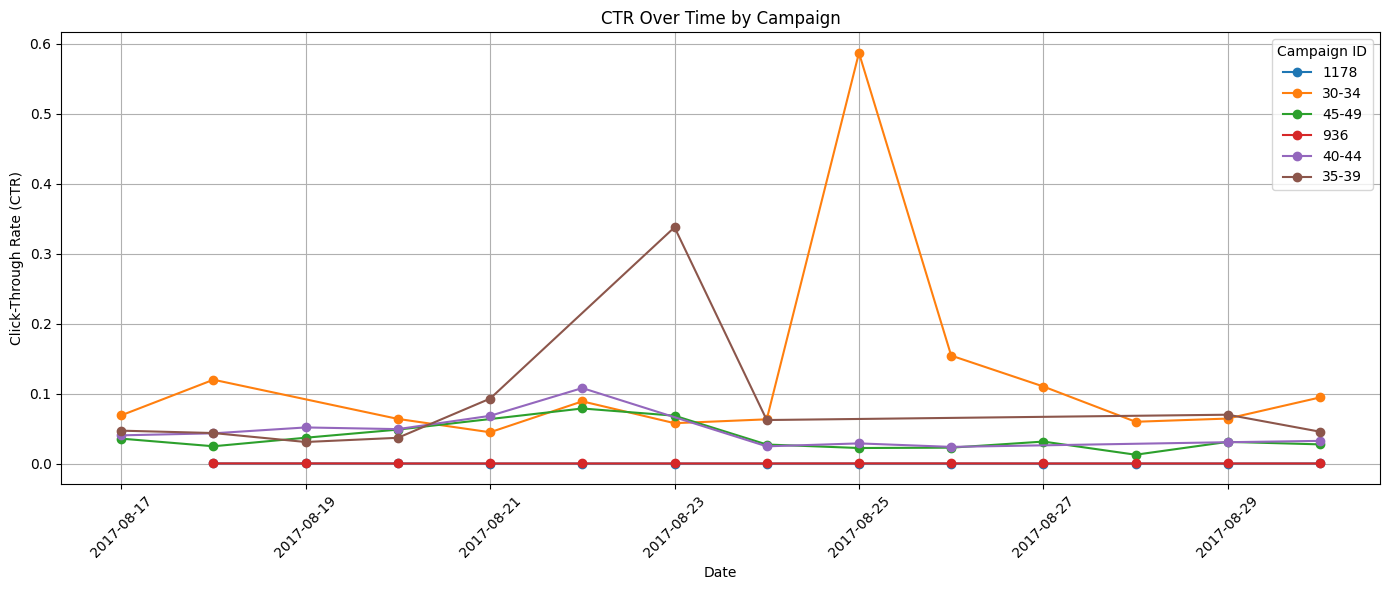

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your DataFrame if not already in memory
# df = pd.read_csv('your_file.csv')

# Convert reporting_start to datetime
df_ctr_over_time['reporting_start'] = pd.to_datetime(df_ctr_over_time['reporting_start'], format='%d/%m/%Y')

# Ensure campaign_id is string (because it includes age groups like '30-34')
df_ctr_over_time['campaign_id'] = df_ctr_over_time['campaign_id'].astype(str)

# Plot top 6 unique campaign_id / groups
unique_ids = df_ctr_over_time['campaign_id'].value_counts().head(6).index.tolist()
df_filtered = df_ctr_over_time[df_ctr_over_time['campaign_id'].isin(unique_ids)]

# Plot
plt.figure(figsize=(14, 6))
for cid in unique_ids:
    plot_data = df_filtered[df_filtered['campaign_id'] == cid]
    plt.plot(plot_data['reporting_start'], plot_data['ctr'], marker='o', label=cid)

plt.title("CTR Over Time by Campaign")
plt.xlabel("Date")
plt.ylabel("Click-Through Rate (CTR)")
plt.xticks(rotation=45)
plt.legend(title="Campaign ID")
plt.grid(True)
plt.tight_layout()
plt.show()

Q4. Are we overspending on low-performing campaigns?

A4. Using the SQL table below, it can be observed that

* Campaign 1178 is the most expensive campaign by far having the highest cost per click (CPC) at $1.73 and the worst efficiency in terms of conversions per dollar (0.0633). It got the most conversions but it's not cost effective.

* Campaign 936 has better efficiency than 1178 but still not optimal (although far cheaper and higher ROI)

* Campaign 916 has the highest conversions per dollar at 0.3874 and delivers 3 times more conversions per dollar than 1178, with very low spend.

In conclusion, campaign 1178 is consuming the largest portion of the budget but has the lowest return on ad spend (ROAS). In contrast, Campaign 916, though modest in scale, delivers the best cost-efficiency and should be prioritized for scaling.


In [49]:
query = '''
SELECT
  campaign_id,
  SUM(spent) AS total_spent,
  SUM(clicks) AS total_clicks,
  SUM(total_conversion) AS total_conversions,
  ROUND(SUM(spent) / NULLIF(SUM(clicks), 0), 2) AS cost_per_click,
  ROUND(SUM(total_conversion) * 1.0 / NULLIF(SUM(spent), 0), 4) AS conversions_per_dollar
FROM facebook_ads
GROUP BY campaign_id
ORDER BY total_spent DESC;
'''

df_spending_performance = pd.read_sql(query, conn)
df_spending_performance


,campaign_id,total_spent,total_clicks,total_conversions,cost_per_click,conversions_per_dollar
0,1178,16577.159998,9577,1050.0,1.73,0.0633
1,936,2893.369999,1984,537.0,1.46,0.1856
2,30-34,166.000000,541,NaN,0.31,NaN
3,45-49,162.000000,521,NaN,0.31,NaN
4,916,149.710001,113,58.0,1.32,0.3874
5,40-44,88.000000,288,NaN,0.31,NaN
6,35-39,78.000000,269,NaN,0.29,NaN


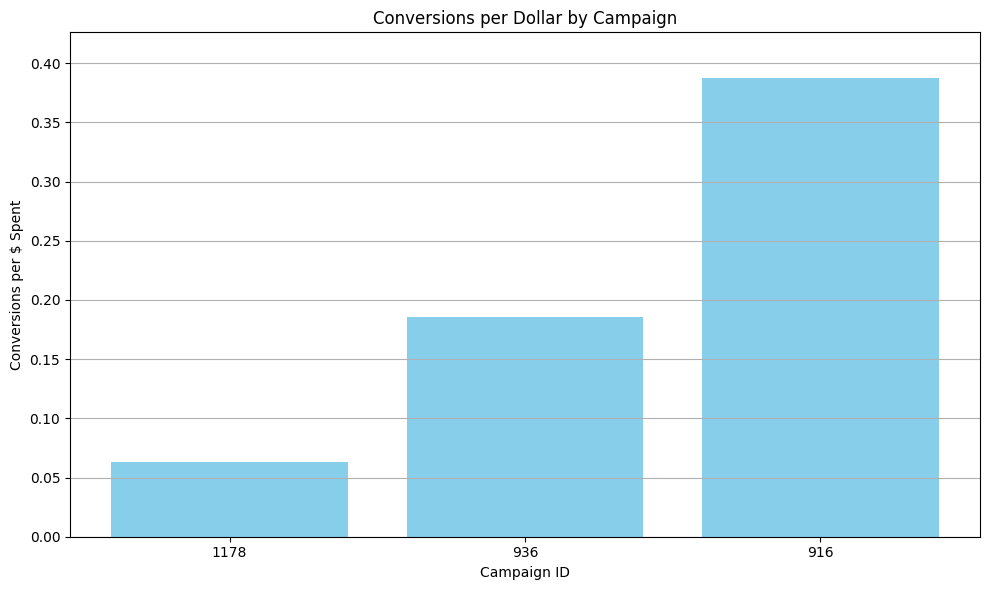

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out rows with missing conversion data
df = df_spending_performance.dropna(subset=['conversions_per_dollar'])

plt.figure(figsize=(10, 6))
plt.bar(df['campaign_id'], df['conversions_per_dollar'], color='skyblue')

plt.title('Conversions per Dollar by Campaign')
plt.xlabel('Campaign ID')
plt.ylabel('Conversions per $ Spent')
plt.ylim(0, df['conversions_per_dollar'].max() * 1.1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()